# Import

In [46]:
import numpy as np 
import scipy as sp
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, to_tree



In [12]:
from module.dendorgram_utils import dendrogram_clustering
from module.data_prep_drosophila import drosophila_data
from module.utils import get_entropy
from fvec import bipartite_cooarray, adjacency_cooarray, csr_row_norm, csr_col_norm

In [13]:
save_things = False
cwd = Path.cwd()


In [ ]:
datadate = '20241119' # date of drosophila VNC data pull
dm_datadir = f'../../data/{datadate}_dm_data'

dm_datadir = cwd.parent.parent / 'data' / '{datadate}_dm_data' 

if save_things:
    dm_processed_dir = dm_datadir / 'processed'
    fig_dir = cwd.parent / 'figures' / 'drosophila'
    fig_dir.mkdir(parents=True, exist_ok=True)

# if save_things:
#     dm_processed_dir = dm_datadir + '/processed'
#     if not os.path.isdir(dm_processed_dir):
#         os.makedirs(dm_processed_dir)


df, meta_df = drosophila_data(datadate=datadate)

In [15]:
meta_df['rois'] = meta_df.apply(lambda row: f"{str(row.somaNeuromere)}" + \
                                                    f"{str(row.somaSide)[:-2]}", axis=1)


In [16]:
hemistring = 'hemilineage'
# hemilineage_fileprefix = f'{dm_datadir}/processed/hemilineage'

sliced_meta = meta_df[['bodyId', hemistring, 'somaSide']].rename(columns={'bodyId':'id'}).copy(True)


In [17]:
rhs_nids = meta_df[meta_df.somaSide=='RHS'].bodyId.values
lhs_nids = meta_df[meta_df.somaSide=='LHS'].bodyId.values

In [18]:

n_ids = sliced_meta.id.sort_values().unique() # all neuron ids

sliced_meta.dropna(inplace=True)# remove nans
remove = ['TBD'] # remove TBD type as well
h_cat_meta = sliced_meta[~sliced_meta[hemistring].isin(remove)]

In [19]:
h_cat_meta['type'] = h_cat_meta.hemilineage + '_' + h_cat_meta.somaSide

/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_50773/878204239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_cat_meta['type'] = h_cat_meta.hemilineage + '_' + h_cat_meta.somaSide


In [20]:
a_NN_coo, _ = adjacency_cooarray(df=df, row_col=['bodyId_pre', 'bodyId_post'], id_order=n_ids, weight=True, directed=True)


In [21]:
bpt_NH_coo, neuron_row, type_col = bipartite_cooarray(df=h_cat_meta, row_col=['id', 'type'], weight=False, row_order=n_ids)

a_NH_out = (a_NN_coo @ bpt_NH_coo).tocsr() # out matrix
a_NH_in = (a_NN_coo.T @ bpt_NH_coo).tocsr() # in matrix

# out matrix normalisation:
a_NH_out_normalised = csr_row_norm(a_NH_out)

# in matrix normalisation:
a_NH_in_normalised = csr_row_norm(a_NH_in)

a_NH_out = (a_NN_coo @ bpt_NH_coo).tocsr() # out matrix
a_NH_in = (a_NN_coo.T @ bpt_NH_coo).tocsr() # in matrix


In [22]:
all_col_names = np.concatenate([
    np.char.add(type_col, '_out'),
    np.char.add(type_col, '_in')
])
all_norm_vec_df = pd.DataFrame(sp.sparse.hstack([a_NH_out_normalised, a_NH_in_normalised]).toarray(), columns=all_col_names, index=neuron_row)

### ipsi-contra labelling of hemilineage vectors

In [23]:
handedness_colnames={}
for handedness in ['RHS', 'LHS']:
    # prepbool = np.zeros(len(all_col_names))
    ic_colname = []
    
    for val in all_col_names:
        if 'Midline' in val:
            ic_colname.append(val)
            continue
        if handedness in val:
            valsplit = val.split('_')
            newval = valsplit[0] + '_I_' + valsplit[-1]
            ic_colname.append(newval)
            continue
        elif handedness not in val: 
            valsplit = val.split('_')
            newval = valsplit[0] + '_C_' + valsplit[-1]
            ic_colname.append(newval)

    handedness_colnames[handedness] = ic_colname


In [24]:
list_to_concat = []
for handedness, ids in zip(['RHS', 'LHS'], [rhs_nids, lhs_nids]):
    handedness_df = all_norm_vec_df.loc[ids,all_col_names].copy(True)
    handedness_df.columns = handedness_colnames[handedness]
    list_to_concat.append(handedness_df)

In [25]:
h_ic_vectors = pd.concat(list_to_concat) # hemilineage connectivity vectors specified by ipsi/contra labelling. 

# Clustering:

In [26]:
method='ward'
metric = 'euclidean'

dist_func = sp.spatial.distance.pdist 

ind_to_id = h_ic_vectors.index.values
Z = linkage(h_ic_vectors, method=method, metric=metric) ####### linkage


In [27]:
# from hemi_20220701.ipynb


rootnode, nodelist = to_tree(Z , rd=True)
bools = [i.is_leaf() for i in nodelist]
opp_bools = list(map(lambda x: not x, bools))


In [28]:

lst = [i.pre_order(lambda x: ind_to_id[x.id]) for i in np.array(nodelist)[opp_bools]] # getting list of all clusters 
# len(lst) is the NUMBER of clusters. 
clstr_sizes = [len(i) for i in lst] # sizes of clusters
cluster_bool = np.array(clstr_sizes) >= 4 # only consider clusters of 6 or larger 
dists = [i.dist for i in np.array(nodelist)[opp_bools]] # getting distances of all clusters 

rel_clusters = np.array(lst, dtype=object)[cluster_bool] # all relevant clusters. 
rel_dists = np.array(dists, dtype=object)[cluster_bool] # all relevant cluster distances.


In [31]:
def get_entropy(vector, delta=1e-8):
    if sum(vector)==0: # if the vector has no contributions, then return np.nan
        return np.nan 

    v = vector[vector > delta]
    entropy = -sum(v * np.log(v))
    
    return entropy


In [32]:

rois = [f'T{i}{j}' for i in [1,2,3] for j in ['L','R']]
# vector = pd.DataFrame(columns=sn_regions)
cluster_dict = {} # keep track of the neuron ids in each cluster. 

for i in range(len(rel_clusters[:])): # cluster labelled from 0
    key_neurons = meta_df[meta_df['bodyId'].isin(rel_clusters[i])].copy(True)    
    key_neurons.set_index('bodyId', inplace=True)
    # cont_dict = key_neurons['rois'].value_counts().to_dict() # contribution to neuromere proportion dictionary. 
    # vector.loc[i] = pd.Series(cont_dict)
    # vector.loc[i].update({'cluster':rel_clusters[i]})
    count_dict = Counter(key_neurons['rois'])
    roi_vector = np.array([count_dict.get(i, 0) for i in rois])
    entropy = get_entropy(roi_vector/sum(roi_vector))
    balance_score = entropy/np.log(6) # normalised entropy balance score
    div = np.exp(entropy) # normalised entropy diversity score
    
    lr_count_dict = Counter(key_neurons['somaSide'])
    lr_vector = np.array([lr_count_dict.get(i, 0) for i in ['RHS', 'LHS']])
    lr_entropy = get_entropy(lr_vector/sum(lr_vector))
    lr_balance_score = lr_entropy/np.log(2) # normalised entropy balance score
    # div = np.exp(entropy) # normalised entropy diversity score


    cluster_dict[i] = {'cluster': rel_clusters[i], 
                       'height':rel_dists[i], 
                       'b_score':balance_score, 
                       'div':div, 
                       'LR_score':lr_balance_score}

    


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_50773/2675254489.py:13: RuntimeWarning: invalid value encountered in divide
  entropy = get_entropy(roi_vector/sum(roi_vector))


In [33]:
all_clusters_ic = pd.DataFrame.from_dict(cluster_dict, orient='index') #
all_clusters_ic['n'] = all_clusters_ic.cluster.apply(len)

# all_clusters_ic = all_clusters_ic.sort_values(by=['LR_score', 'b_score', 'n'], ascending=[False, False, True]).reset_index(drop=True)
all_clusters_ic = all_clusters_ic.sort_values(by=['LR_score', 'b_score', 'n'], ascending=[False, False, True]).reset_index(drop=True)

In [34]:
all_clusters_ic

,cluster,height,b_score,div,LR_score,n
0,"[12036, 12348, 10773, 11790, 12043, 12166]",0.108638,1.0,6.0,1.0,6
1,"[10956, 10910, 11124, 10444, 11010, 11056]",0.114960,1.0,6.0,1.0,6
2,"[12988, 12642, 12629, 11117, 14072, 16303]",0.116526,1.0,6.0,1.0,6
3,"[15168, 16916, 15510, 15389, 11952, 14704]",0.123113,1.0,6.0,1.0,6
4,"[11990, 11524, 11159, 10796, 10442, 11237]",0.127669,1.0,6.0,1.0,6
...,...,...,...,...,...,...
7209,"[23243, 23715, 23439, 22136, 21549, 100553]",0.222915,-0.0,1.0,-0.0,6
7210,"[24977, 34730, 31636, 165694, 26598, 26843]",0.264104,-0.0,1.0,-0.0,6
7211,"[33851, 155783, 32459, 36855, 31282, 32164]",0.353858,-0.0,1.0,-0.0,6
7212,"[16633, 17454, 153354, 12580, 11550, 14555]",0.413104,-0.0,1.0,-0.0,6


In [77]:
# sns.histplot(all_clusters_ic.dropna().b_score)

In [78]:
# sns.histplot(all_clusters_ic.dropna()['div'])

In [35]:
total = set()
save = []
for i in range(len(all_clusters_ic)):
    clstr = all_clusters_ic.iloc[i].cluster
    if len(total & set(clstr)) == 0:
        save.append(i)
        total |= set(clstr)

len(save)


1896

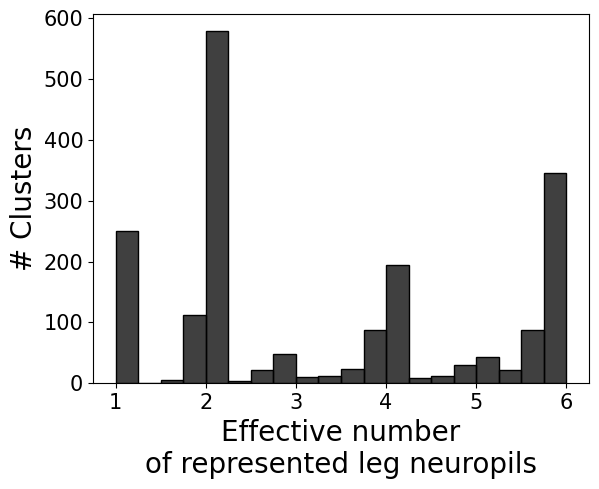

In [36]:

sns.histplot(all_clusters_ic.loc[save]['div'], bins=20, color='black')
plt.xlabel('Effective number\nof represented leg neuropils', size=20)
plt.ylabel('# Clusters', size=20)
plt.xticks(size=15)
plt.yticks(size=15)

if save_things:
    plt.savefig(fig_dir / 'dm_div.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(fig_dir / 'dm_div.png', dpi=300, bbox_inches='tight')

plt.show()

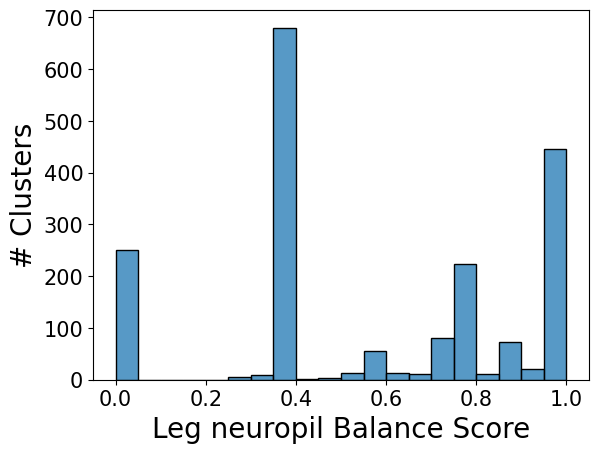

In [ ]:
sns.histplot(all_clusters_ic.loc[save]['b_score'], bins=20)
plt.xlabel('Leg neuropil Balance Score', size=20)
plt.ylabel('# Clusters', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
if save_things:
    plt.savefig(fig_dir / 'dm_ent.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(fig_dir / 'dm_ent.png', dpi=300, bbox_inches='tight')

plt.show()

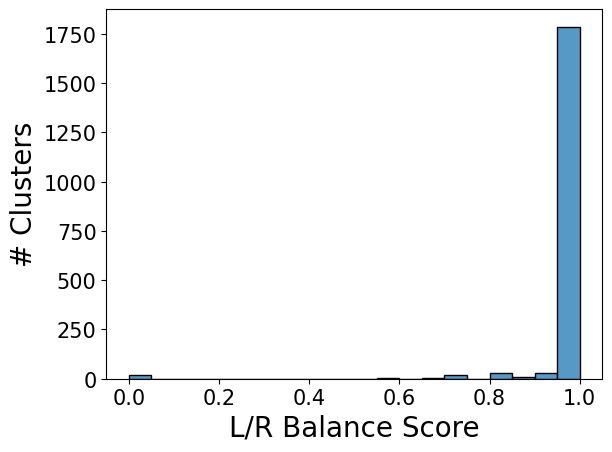

In [38]:
sns.histplot(all_clusters_ic.loc[save]['LR_score'], bins=20)
plt.xlabel('L/R Balance Score', size=20)
plt.ylabel('# Clusters', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
# if save_things:
    # plt.savefig(fig_dir / 'dm_ent.pdf', dpi=300)
    # plt.savefig(fig_dir / 'dm_ent.png', dpi=300)

plt.show()

In [29]:
# proposed_groups = all_clusters_ic.loc[save].cluster.values
# # proposed_serials = all_clusters_ic.loc[save].query('div>5.999').cluster.values

# group_len = []
# for clstr in proposed_groups:
#     group_set = set(meta_df[meta_df['bodyId'].isin(clstr)].group)
#     print(group_set)
#     group_len.append(len(group_set))


In [30]:
# sum([i==1 for i in group_len])

In [39]:
# cluster evaluation:
proposed_serials = all_clusters_ic.loc[save].query('div>5.999').cluster.values
# proposed_serials = all_clusters_ic.loc[save].query('div>5.999').cluster.values

set_len = []
for clstr in proposed_serials:
    ser_set = set(meta_df[meta_df['bodyId'].isin(clstr)].serial)
    # print(ser_set)
    set_len.append(len(ser_set))


## Dendrogram 

In [33]:
# meta_df[meta_df.somaNeuromere.isin([f'T{i}' for i in [1,2,3]])]

In [40]:
intrinsic_neurons = meta_df[meta_df['class'].isin(['intrinsic neuron'])].bodyId.values
leg_neurons = meta_df[meta_df['somaNeuromere'].isin([f'T{i}' for i in '123'])].bodyId.values

intrinsic_neuron_vectors = h_ic_vectors[h_ic_vectors.index.isin(intrinsic_neurons)]
intrinsic_legneuron_vectors = h_ic_vectors[(h_ic_vectors.index.isin(intrinsic_neurons))&(h_ic_vectors.index.isin(leg_neurons))]

In [41]:
vector_df = h_ic_vectors

In [42]:
method='ward'
metric = 'euclidean'

dist_func = sp.spatial.distance.pdist 

ind_to_id = vector_df.index.values
Z = linkage(vector_df, method=method, metric=metric) ####### linkage


In [43]:
rel_meta_df = meta_df.set_index('bodyId')
rel_meta_df = rel_meta_df.loc[ind_to_id]

In [44]:
# rois = [f'T{i}{j}' for i in [1,2,3] for j in ['L','R']]
somaNeuromeres = [f'T{i}' for i in [1,2,3]]

In [47]:
# cs=['#CC3D24FF','#F3C558FF', '#6DAE90FF', '#30B4CCFF', '#004F7AFF']
lr_cs = ['#EE2617FF', '#0E54B6FF']
# cs = ["#6497B1FF",  '#FFB04FFF','#6A359CFF', '#CD1076FF',  '#679C35FF',]

cs = ['#462255FF', '#FF8811FF', '#9DD9D2FF', '#046E8FFF', '#D44D5CFF']
rgba_colors = np.array([to_rgba(color) for color in cs])

In [48]:
cat_to_plot = ['somaSide', 'somaNeuromere']
keep_cats = [None, somaNeuromeres]
cols = [lr_cs, cs]
# tf_ids = ud_vect_df.index.values # ordered transcription factor names (all) 

plotobj = []

for cat, keep, c in zip(cat_to_plot, keep_cats, cols):
    rgba_colors = np.array([to_rgba(color) for color in c])
    unique_cats = rel_meta_df[cat].unique()
    print(unique_cats)
    if keep is None:
        keep = list(unique_cats)


    # arr, key = pd.factorize(list(rel_meta_df[cat]))

    arr, key = pd.factorize(keep + list(rel_meta_df[cat]))
    arr = arr[len(keep):]
    key = key[:len(keep)]
    
    # colors = cm.gnuplot(np.linspace(0,1,len(key)))
    colors = (rgba_colors[:len(key)])

    node_to_clusterid_arr = np.array([i if i < len(keep) else -1 for i in arr ]) # if not in enriched cluster, label as -1. 

    if -1 in node_to_clusterid_arr:
        colors = np.vstack([[1,1,1,1], colors])
    cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    plotobj.append((node_to_clusterid_arr, key, cluster_cmap))
    # cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    # plotobj.append((arr, key, cluster_cmap))


['RHS' 'LHS']
['T2' 'T1' 'T3' 'A4' 'A2' 'A8' 'A1' 'A7' 'A6' 'A3' 'A10' 'A9' 'A5']


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_50773/3602671895.py:18: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  arr, key = pd.factorize(keep + list(rel_meta_df[cat]))


In [49]:
cl_df = all_clusters_ic.loc[save]

In [50]:
white_to_green = LinearSegmentedColormap.from_list("white_to_green", ["white", "green"])

In [51]:
cluster_df_todict = cl_df.to_dict()
index_keys = cluster_df_todict.keys()
cluster_dict = cl_df.cluster.to_dict()


In [52]:
id_balance_dict = {}
for c_id, cl in cluster_dict.items():
    for nid in cl:
        id_balance_dict[nid] = cluster_df_todict.get('b_score').get(c_id)

ind_to_balance = np.array([id_balance_dict.get(i, 0) for i in ind_to_id])

In [53]:
id_lr_balance_dict = {}
for c_id, cl in cluster_dict.items():
    for nid in cl:
        id_lr_balance_dict[nid] = cluster_df_todict.get('LR_score').get(c_id)

ind_to_lr_balance = np.array([id_lr_balance_dict.get(i, 0) for i in ind_to_id])

In [56]:
formatter = {'somaSide':'Side', 'somaNeuromere':'Neuromere'}

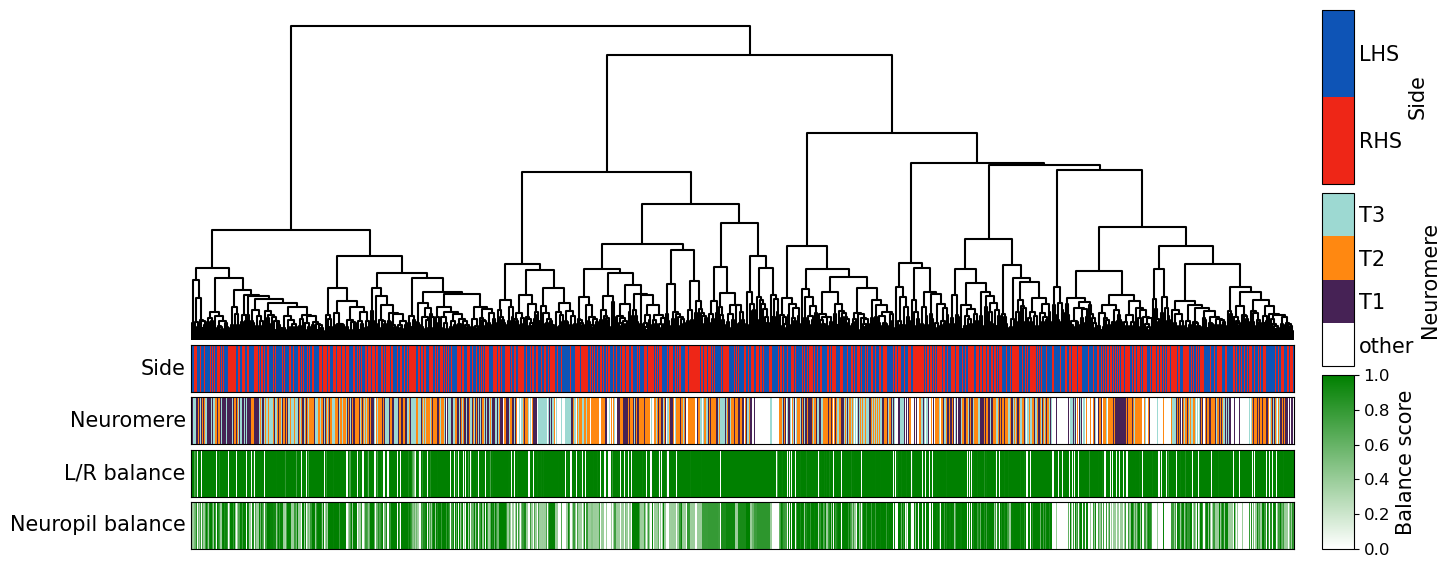

In [58]:
ncats = len(cat_to_plot) +2

fig = plt.figure(figsize=(15, 3+ncats))
# fig.suptitle(f'{M} neighbours', fontsize=16)


gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)

gs1 = GridSpecFromSubplotSpec(1+ncats,1, subplot_spec=gs0[0],
                                                  height_ratios=[7] + [1 for _ in range(ncats)],
                                                  hspace=0.05)

gs2 = GridSpecFromSubplotSpec(ncats-1,1, subplot_spec=gs0[1],
                                                  height_ratios=[1 for _ in range(ncats-1)],
                                                  hspace=0.05)




ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black')
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

for n in range(len(plotobj)):
    legend_ax = fig.add_subplot(gs2[n])

    arr, key, cluster_cmap = plotobj[n]

    if -1 in arr:
        key = ['other'] + list(key) # if we want white space for not represented 
    
    ax = fig.add_subplot(gs1[1+n], sharex=ax_col_dendrogram)
    colrow = ax.imshow(arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
    ax.set_yticks([])
    label = formatter.get(cat_to_plot[n], cat_to_plot[n])
    ax.set_ylabel(label, rotation=0, ha='right', va='center', size='15')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)

    cbar = fig.colorbar(colrow, cax=legend_ax, label=label)
    yticks = np.linspace(*legend_ax.get_ylim(), len(key)+1)[:-1] + ((legend_ax.get_ylim()[1]-legend_ax.get_ylim()[0]) / len(key) / 2)

    cbar.set_label(label, size=15)  # Set label text and size
    legend_ax.set_yticks(ticks=yticks)
    legend_ax.tick_params(axis='y', labelsize=15)
    legend_ax.set_yticklabels(key, size=15)
    legend_ax.tick_params(length=0)




# legend_ax = fig.add_subplot(gs2[-2])

ax = fig.add_subplot(gs1[-2], sharex=ax_col_dendrogram)
colrow = ax.imshow(ind_to_lr_balance[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_green, interpolation='nearest')
ax.set_yticks([])
ax.set_ylabel('L/R balance', rotation=0, ha='right', va='center', size=15)
ax.set_xticks([])
plt.setp(ax.get_xticklabels(), visible=False)

# cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])

# cbar.set_label('L/R balance', size=12)  # Set label text and size
# legend_ax.tick_params(axis='y', labelsize=12)


legend_ax = fig.add_subplot(gs2[-1])

ax = fig.add_subplot(gs1[-1], sharex=ax_col_dendrogram)
colrow = ax.imshow(ind_to_balance[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_green, interpolation='nearest')
ax.set_yticks([])
ax.set_ylabel('Neuropil balance', rotation=0, ha='right', va='center', size=15)
ax.set_xticks([])
plt.setp(ax.get_xticklabels(), visible=False)

cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])

cbar.set_label('Balance score', size=15)  # Set label text and size
legend_ax.tick_params(axis='y', labelsize=12)
save_things=False
if save_things:
    plt.savefig(fig_dir / 'dm_v_clustering.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(fig_dir / 'dm_v_clustering.png', dpi=300, bbox_inches='tight')
plt.show()